# SIT742: Modern Data Science
**(Module: Big Data)**

---
- Materials in this module include resources collected from various open-source online repositories.
- You are free to use, change and distribute this package.
- If you found any issue/bug for this document, please submit an issue at [tulip-lab/sit742](https://github.com/tulip-lab/sit742/issues)


Prepared by **SIT742 Teaching Team**

---


## Session 6D: Generative Adversaial Network on Image Data Generation

In this session, we will learn how to use GAN to do image generation



### Content


1. `GAN` Basics

2. Loading `Image` Data

3. Data Generation through `GAN`

4. Image processing and ploting.



**Note**: The data available on those service might be changing, so you need to adjust the code to accommodate those changes.

In [1]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from matplotlib import pyplot
import numpy as np

from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout

<a id = "cell_data"></a>
### 1. Data Loading

Mnist Dataset is large database of handwritten digits that is commonly used for training various image processing systems. The MNIST database contains 60,000 training images and 10,000 testing images.

We are going to use the training images for this experiment.
You can download this sample data set from `keras.datasets.mnist`

In [2]:
from keras.datasets.mnist import load_data
def load_real_samples():
 # load mnist dataset
 (trainX, _), (_, _) = load_data()
 # expand to 3d, e.g. add channels dimension
 X = expand_dims(trainX, axis=-1)
 # convert from unsigned ints to floats
 X = X.astype('float32')
 # scale from [0,255] to [0,1]
 X = X / 255.0
 return X

dataset = load_real_samples()

11490434/11490434 [==============================] - 0s 0us/step


View some images in this sample data set.

In [3]:
dataset.shape

(60000, 28, 28, 1)

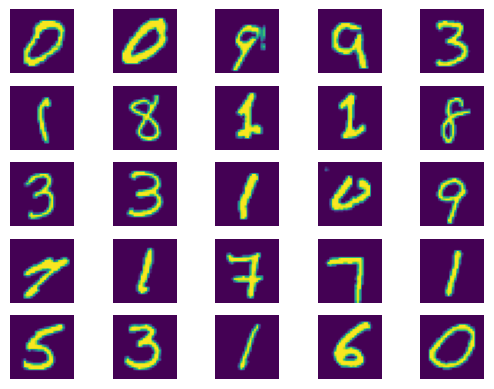

In [4]:
def show_images(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i])
    pyplot.show()

Sample_Original = dataset[np.random.choice(dataset.shape[0], size=25, replace=False)]
show_images(Sample_Original, 5)

<a id = "cell_GAN"></a>
### 2. GAN Model Construction


![](https://drive.google.com/uc?export=view&id=1URRiWgWq2Dmhoj2Jl55XbieDjdtaYL_O)

For GAN, it has two parts working together, `generator` and `discriminator`.
How to Define Generator and Discriminator network architecture?


1.   Define the Discriminator as a classification NN
2.   Define the Generator based on the input and output dimension

Then how does the GAN get trained?

1.   Train the Generator model to generate the fake data that can fool Discriminator
2.   Train the Discriminator model to distinguish real vs fake data
1.   Continue the training for several epochs and save the Generator model






In [5]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
 model = Sequential()
 model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
 model.add(LeakyReLU(alpha=0.2))
 model.add(Dropout(0.4))
 model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
 model.add(LeakyReLU(alpha=0.2))
 model.add(Dropout(0.4))
 model.add(Flatten())
 model.add(Dense(1, activation='sigmoid'))
 # compile model
 opt = Adam(lr=0.0002, beta_1=0.5)
 model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
 return model

Here, We define the standalone `Generator` Model as follows:

it takes a point from the latent space as input and generates a single 28×28 color image as output (the output dimension of mnist image). Initially, a fully connected layer interprets the latent space point and generates sufficient activations, which are then reshaped into multiple (in this case, 128) low-resolution versions of the output image (e.g., 7×7). These low-resolution images are then upsampled twice using transpose convolutional layers, doubling the size and quadrupling the area of the activations with each upsampling step.

The generator could be modified with more complex structure (more conv layers) for high resolution images.

In [6]:
# define the standalone generator model
def define_generator(latent_dim):
 model = Sequential()
 # foundation for 7x7 image
 n_nodes = 128 * 7 * 7
 model.add(Dense(n_nodes, input_dim=latent_dim))
 model.add(LeakyReLU(alpha=0.2))
 model.add(Reshape((7, 7, 128)))
 # upsample to 14x14
 model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
 model.add(LeakyReLU(alpha=0.2))
 # upsample to 28x28
 model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
 model.add(LeakyReLU(alpha=0.2))
 model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
 return model

The **define_gan()** function below takes as arguments the already-defined `generator and discriminator` models and creates the new logical third model subsuming these two models. The weights in the discriminator are marked as not trainable, which only affects the weights as seen by the GAN model and not the standalone discriminator model.

The GAN model then uses the same binary cross entropy loss function as the discriminator and the efficient Adam version of stochastic gradient descent with the learning rate of 0.0002 and momentum 0.5, recommended when training deep convolutional GANs.
Those parameters could be changed by different scenarios.

In [7]:
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

Define the function for select the real images for `discriminator` to train.

In [8]:
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y

Define the function for giving input of `Generator`.
The `x_input` is the random noise and used as the input for `Generator`.

In [9]:
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

Define the function for generating the `synthetic images` (fake one) and give the label for later `discriminator` usage.

In [10]:
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

In [11]:
from matplotlib import pyplot
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
 # plot images
 for i in range(n * n):
 # define subplot
  pyplot.subplot(n, n, 1 + i)
 # turn off axis
  pyplot.axis('off')
 # plot raw pixel data
  pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
 # save plot to file
  filename = 'generated_plot_e%03d.png' % (epoch+1)
  pyplot.savefig(filename)
  pyplot.close()

Training for GAN usually takes a lot of epoches.
Every few epoches, the performance of the `discriminator` will be evaluated. Idealy, if `discriminator` can not distinguish the true and fake images, then the GAN is well trained.

In [12]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
 # prepare real samples
 X_real, y_real = generate_real_samples(dataset, n_samples)
 # evaluate discriminator on real examples
 _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
 # prepare fake examples
 x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
 # evaluate discriminator on fake examples
 _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
 # summarize discriminator performance
 print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
 # save plot
 save_plot(x_fake, epoch)
 # save the generator model tile file
 filename = 'generator_model_%03d.h5' % (epoch + 1)
 g_model.save(filename)

Define the overall training for the whole GAN including generator and discriminator.

In [13]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # create training set for the discriminator
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
        # evaluate the model performance, sometimes
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

<a id = "cell_GAN_train"></a>
### 3. Train GAN model

Before training the GAN model, the generator and discrimintor require to be defined.
By viewing the GAN structure, what you could observe?



1.   The generator and discriminator take turns for training, therefore, the loss will be back-propagate from discriminator to generator.
2.   The GAN is a connected NN by combining the generator and discriminator.

How does the GAN get optimized?

\begin{equation}
\min_G \max_D V(D, G)
\end{equation}
where :
\begin{equation}
V(D, G) = \mathbb{E}_{\mathbf{x} \sim p_{\text{data}}(\mathbf{x})} [\log D(\mathbf{x})] + \mathbb{E}_{\mathbf{z} \sim p_{\mathbf{z}}(\mathbf{z})} [\log (1 - D(G(\mathbf{z})))]
\end{equation}

Here, the x represents the real image sampled from the image database,
the z represents the random noise. The G is the generator and D is the discriminator. The goal is for the generator to produce data that the discriminator cannot distinguish from real data, while the discriminator aims to correctly identify real versus generated data




In [14]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan models
print(d_model.summary())
print(g_model.summary())
print(gan_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0

Train the entire GAN model. ***This step will take around 15- 30 mins with GPU***.
If you are not in GPU session, please skip to next code cell.

In [15]:
train(g_model=g_model, d_model=d_model, gan_model=gan_model, dataset=dataset, latent_dim=latent_dim,n_epochs=50)

4/4 [==============================] - 3s 4ms/step
>1, 1/234, d=0.709, g=0.758
4/4 [==============================] - 0s 3ms/step
>1, 2/234, d=0.669, g=0.839
4/4 [==============================] - 0s 3ms/step
>1, 3/234, d=0.635, g=0.896
4/4 [==============================] - 0s 3ms/step
>1, 4/234, d=0.627, g=0.877
4/4 [==============================] - 0s 3ms/step
>1, 5/234, d=0.636, g=0.775
4/4 [==============================] - 0s 3ms/step
>1, 6/234, d=0.633, g=0.705
4/4 [==============================] - 0s 3ms/step
>1, 7/234, d=0.603, g=0.691
4/4 [==============================] - 0s 3ms/step
>1, 8/234, d=0.560, g=0.694
4/4 [==============================] - 0s 3ms/step
>1, 9/234, d=0.512, g=0.698
4/4 [==============================] - 0s 3ms/step
>1, 10/234, d=0.470, g=0.705
4/4 [==============================] - 0s 3ms/step
>1, 11/234, d=0.440, g=0.710
4/4 [==============================] - 0s 3ms/step
>1, 12/234, d=0.405, g=0.717
4/4 [==============================] - 0s 3ms/ste

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 5ms/step
>11, 1/234, d=0.688, g=0.724
4/4 [==============================] - 0s 4ms/step
>11, 2/234, d=0.687, g=0.674
4/4 [==============================] - 0s 4ms/step
>11, 3/234, d=0.686, g=0.648
4/4 [==============================] - 0s 3ms/step
>11, 4/234, d=0.691, g=0.664
4/4 [==============================] - 0s 3ms/step
>11, 5/234, d=0.689, g=0.727
4/4 [==============================] - 0s 4ms/step
>11, 6/234, d=0.687, g=0.754
4/4 [==============================] - 0s 3ms/step
>11, 7/234, d=0.699, g=0.736
4/4 [==============================] - 0s 4ms/step
>11, 8/234, d=0.697, g=0.679
4/4 [==============================] - 0s 3ms/step
>11, 9/234, d=0.690, g=0.671
4/4 [==============================] - 0s 3ms/step
>11, 10/234, d=0.689, g=0.715
4/4 [==============================] - 0s 3ms/step
>11, 11/234, d=0.684, g=0.738
4/4 [==============================] - 0s 3ms/step
>11, 12/234, d=0.686, g=0.750
4/4 [==============================] 

4/4 [==============================] - 0s 4ms/step
>21, 1/234, d=0.696, g=0.606
4/4 [==============================] - 0s 4ms/step
>21, 2/234, d=0.695, g=0.665
4/4 [==============================] - 0s 4ms/step
>21, 3/234, d=0.696, g=0.795
4/4 [==============================] - 0s 4ms/step
>21, 4/234, d=0.695, g=0.692
4/4 [==============================] - 0s 4ms/step
>21, 5/234, d=0.697, g=0.693
4/4 [==============================] - 0s 4ms/step
>21, 6/234, d=0.688, g=0.764
4/4 [==============================] - 0s 4ms/step
>21, 7/234, d=0.686, g=0.740
4/4 [==============================] - 0s 4ms/step
>21, 8/234, d=0.688, g=0.677
4/4 [==============================] - 0s 4ms/step
>21, 9/234, d=0.691, g=0.736
4/4 [==============================] - 0s 3ms/step
>21, 10/234, d=0.684, g=0.719
4/4 [==============================] - 0s 3ms/step
>21, 11/234, d=0.687, g=0.641
4/4 [==============================] - 0s 4ms/step
>21, 12/234, d=0.688, g=0.723
4/4 [==============================] 

4/4 [==============================] - 0s 5ms/step
>31, 1/234, d=0.685, g=0.687
4/4 [==============================] - 0s 4ms/step
>31, 2/234, d=0.702, g=0.673
4/4 [==============================] - 0s 4ms/step
>31, 3/234, d=0.695, g=0.764
4/4 [==============================] - 0s 4ms/step
>31, 4/234, d=0.684, g=0.679
4/4 [==============================] - 0s 4ms/step
>31, 5/234, d=0.694, g=0.698
4/4 [==============================] - 0s 4ms/step
>31, 6/234, d=0.694, g=0.716
4/4 [==============================] - 0s 4ms/step
>31, 7/234, d=0.696, g=0.744
4/4 [==============================] - 0s 4ms/step
>31, 8/234, d=0.681, g=0.695
4/4 [==============================] - 0s 3ms/step
>31, 9/234, d=0.691, g=0.724
4/4 [==============================] - 0s 3ms/step
>31, 10/234, d=0.689, g=0.718
4/4 [==============================] - 0s 4ms/step
>31, 11/234, d=0.690, g=0.668
4/4 [==============================] - 0s 3ms/step
>31, 12/234, d=0.695, g=0.695
4/4 [==============================] 

4/4 [==============================] - 0s 4ms/step
>41, 1/234, d=0.686, g=0.700
4/4 [==============================] - 0s 5ms/step
>41, 2/234, d=0.687, g=0.722
4/4 [==============================] - 0s 5ms/step
>41, 3/234, d=0.689, g=0.701
4/4 [==============================] - 0s 4ms/step
>41, 4/234, d=0.682, g=0.675
4/4 [==============================] - 0s 4ms/step
>41, 5/234, d=0.696, g=0.711
4/4 [==============================] - 0s 4ms/step
>41, 6/234, d=0.680, g=0.743
4/4 [==============================] - 0s 4ms/step
>41, 7/234, d=0.690, g=0.716
4/4 [==============================] - 0s 3ms/step
>41, 8/234, d=0.685, g=0.713
4/4 [==============================] - 0s 3ms/step
>41, 9/234, d=0.686, g=0.762
4/4 [==============================] - 0s 4ms/step
>41, 10/234, d=0.688, g=0.696
4/4 [==============================] - 0s 3ms/step
>41, 11/234, d=0.686, g=0.674
4/4 [==============================] - 0s 3ms/step
>41, 12/234, d=0.693, g=0.735
4/4 [==============================] 


<a id = "cell_GAN_use"></a>
### 4. Image Generation with GAN

Loading the generator model and generating new images

1/1 [==============================] - 0s 335ms/step


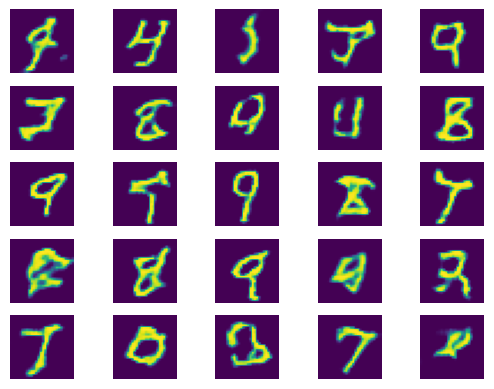

In [16]:
from tensorflow.keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# load model after 10 epoch
model = load_model('generator_model_010.h5', compile=False)

# generate images
latent_points = generate_latent_points(latent_dim, 25)
# generate images
X = model.predict(latent_points)
# plot the result
show_images(X, 5)

#Run the above cole multiple times to see different images being generated.

1/1 [==============================] - 0s 98ms/step


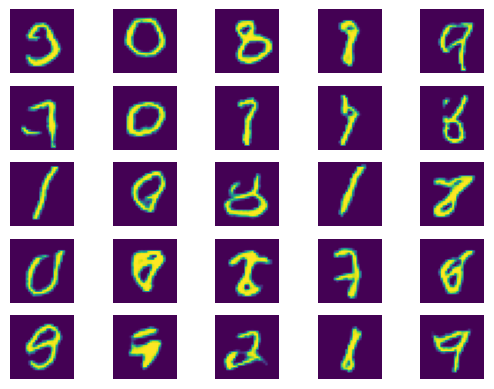

In [17]:
# load model after 100 epoch
model = load_model('generator_model_050.h5', compile=False)

# generate images
latent_points = generate_latent_points(latent_dim, 25)
# generate images
X = model.predict(latent_points)
# plot the result
show_images(X, 5)

**The synthetic mnist data from epoch 0 to 200**

![](https://drive.google.com/uc?export=view&id=1sK3EwgO0lTy0XSd4m8i3asA90kzMyEeu)

There are many other GAN for image generation. Due to the limitation of GPU, we can not run big GAN as example here, but you could try later if you have more time.



1.   Avatar GAN https://github.com/aakashjhawar/AvatarGAN/blob/master/README.md
2.   PIX2PIX GAN https://github.com/phillipi/pix2pix

1.   DCGAN https://github.com/carpedm20/DCGAN-tensorflow
2.   CycleGAN https://github.com/junyanz/CycleGAN






Avatar GAN Example from epoch 0 to 100 (50 mins to 1.5 hours training time)

![](https://drive.google.com/uc?export=view&id=1YBqlqL1N3gthVxJ8x5D6fP5FkKAbeWJi)

**Reference:**

Goodfellow, I., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., ... & Bengio, Y. (2020). Generative adversarial networks. Communications of the ACM, 63(11), 139-144.

*Also see: https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/*

https://arxiv.org/abs/1406.2661